In [1]:
using Revise

In [2]:
import QuantumCollocation as QC
import NamedTrajectories as NT
import TrajectoryIndexingUtils as NTidx
import Plots
import LinearAlgebra as LA
import SparseArrays as SA
import ForwardDiff as FD
using LaTeXStrings

In [3]:
include("utils.jl")
include("system.jl")
include("objectives.jl")
include("constraints.jl")

FinalYZGreatCircleConstraint (generic function with 1 method)

In [4]:
V = 10.
trunc = 11
# E_R [kHz] found in Weidner thesis
system = ShakenLatticeSystem1D(
    V, 
    trunc; 
    acc=0.0, 
    bloch_basis=true,
    bloch_transformation_trunc=2*trunc,
    include_acc_derivative=true, 
    sparse=false)
# middle index of statevector where p = 0
mid = system.params[:mid]
dim = system.params[:dim]
B = system.params[:bloch_states][:,1:trunc]
if system.params[:accelerated]
    B2 = blockdiagonal(B, B)
end

46×22 SparseArrays.SparseMatrixCSC{ComplexF64, Int64} with 506 stored entries:
⎡⣿⣿⣿⣿⣿⡇⠀⠀⠀⠀⠀⎤
⎢⣿⣿⣿⣿⣿⡇⠀⠀⠀⠀⠀⎥
⎢⣿⣿⣿⣿⣿⡇⠀⠀⠀⠀⠀⎥
⎢⣿⣿⣿⣿⣿⡇⠀⠀⠀⠀⠀⎥
⎢⣿⣿⣿⣿⣿⡇⠀⠀⠀⠀⠀⎥
⎢⠿⠿⠿⠿⠿⢇⣀⣀⣀⣀⣀⎥
⎢⠀⠀⠀⠀⠀⢸⣿⣿⣿⣿⣿⎥
⎢⠀⠀⠀⠀⠀⢸⣿⣿⣿⣿⣿⎥
⎢⠀⠀⠀⠀⠀⢸⣿⣿⣿⣿⣿⎥
⎢⠀⠀⠀⠀⠀⢸⣿⣿⣿⣿⣿⎥
⎢⠀⠀⠀⠀⠀⢸⣿⣿⣿⣿⣿⎥
⎣⠀⠀⠀⠀⠀⠘⠛⠛⠛⠛⠛⎦

In [237]:
system.H_drift_real

22×22 Matrix{Float64}:
  1.16045      -3.81709e-15  -1.95634      …   0.0           0.0
 -3.81714e-15   4.48243       2.87773e-15      0.0           0.0
 -1.95634       2.87756e-15   3.41669          0.0           0.0
 -6.00755e-13   2.38146       2.17156e-12      0.0           0.0
  0.699748      3.00751e-12  -2.52663          0.0           0.0
  8.57346e-11  -0.192284     -4.23322e-10  …   0.0           0.0
  0.0465362     3.54247e-10  -0.229777         0.0           0.0
  1.76779e-8    0.00533246   -9.66794e-8       0.0           0.0
  0.0012026    -7.83853e-8   -0.00657698       0.0           0.0
  1.67673e-6    7.34672e-5   -9.59911e-6       0.0           0.0
  ⋮                                        ⋱   ⋮            
  0.0           0.0           0.0             -9.59911e-6   -9.1839e-5
  0.0           0.0           0.0              0.001354     -0.000141521
  0.0           0.0           0.0          …   0.000141544   0.00135422
  0.0           0.0           0.0             -0.0

In [317]:
duration = 2pi * 0.5 # in units of 1/E_R

T = 500
dt = duration / (T-1)
dts = zeros(T) .+ dt
dt_bound = (dt, dt)
times = cumsum(dts) - dts;

In [318]:
phi_bound = [1.0*pi]

#a = vcat(ones(T)', zeros(T)') 
#a = vcat(cos.(2pi * times/duration)', sin.(2pi * times/duration)')
#a = vcat(cos.(1. .+ 0.5*cos.(2π* 12. *times))', sin.(1. .+ 0.5*cos.(2π* 12. *times))')

# phi = 0.5 * (cos.(2pi * 4. * times) + cos.(2pi * 12. * times))
phi = rand(1, T)
#phi = zeros(1, T)
a = vcat(cos.(phi), sin.(phi))
acc = collect(times')

dphi = NT.derivative(phi, dts)
ddphi = NT.derivative(dphi, dts)

1×500 Matrix{Float64}:
 -27281.6  6727.12  14664.5  -28972.3  …  -522.699  -14782.1  15157.0  0.0

Z_split = NT.load_traj("interferometer/split_victor.jld2")
Z_mirror = NT.load_traj("interferometer/mirror_victor.jld2")

Z_split = NT.load_traj("interferometer/split_victor_opt2.jld2")
Z_mirror = NT.load_traj("interferometer/mirror_victor2_opt2.jld2")

a, dts = get_interferometer(Z_split, Z_mirror, [])

Z = NT.load_traj("./end2end/traj.jld2")

phi, dts_old = Z.phi, vec(Z.dts)

duration = sum(dts_old) - dts_old[1] # in units of 1/E_R
T = 1001
dt = duration / (T-1)
dts = zeros(T) .+ dt
dt_bound = (dt, dt)
times = cumsum(dts) - dts

phi = interpolate_controls(phi, dts_old, dts)

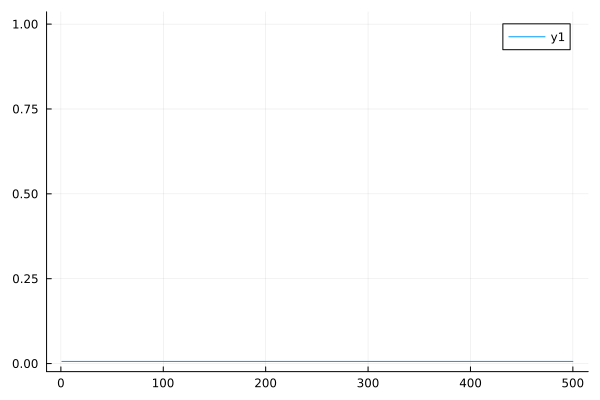

In [321]:
Plots.plot(dts)

In [322]:
duration = sum(dts) - dts[1] # in units of 1/E_R

T = length(dts)
dt = duration / (T-1)
dts = zeros(T) .+ dt
dt_bound = (dt, dt)
times = cumsum(dts) - dts;

In [323]:
times

500-element Vector{Float64}:
 0.0
 0.006295776860901389
 0.012591553721802779
 0.018887330582704167
 0.025183107443605558
 0.031478884304506946
 0.037774661165408334
 0.04407043802630972
 0.05036621488721111
 0.056661991748112504
 ⋮
 3.0912264387025883
 3.09752221556349
 3.1038179924243914
 3.1101137692852925
 3.116409546146194
 3.1227053230070956
 3.129001099867997
 3.1352968767288987
 3.1415926535897998

In [324]:
phi_bound = [1.0 * pi]

a = vcat(cos.(phi), sin.(phi))
acc = collect(times')

dphi = NT.derivative(phi, dts)
ddphi = NT.derivative(dphi, dts)

1×500 Matrix{Float64}:
 -27281.6  6727.12  14664.5  -28972.3  …  -522.699  -14782.1  15157.0  0.0

In [325]:
acc

1×500 Matrix{Float64}:
 0.0  0.00629578  0.0125916  0.0188873  …  3.12271  3.129  3.1353  3.14159

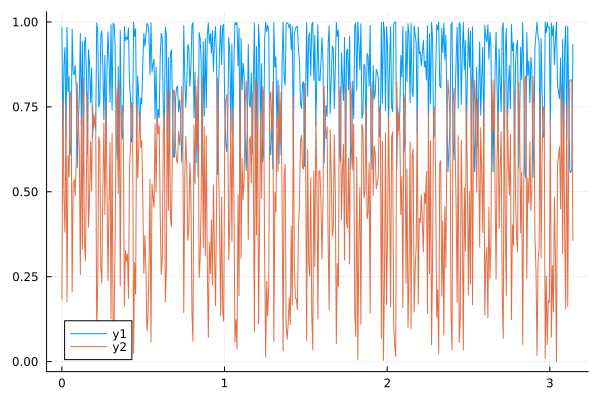

In [326]:
Plots.plot(times, a')

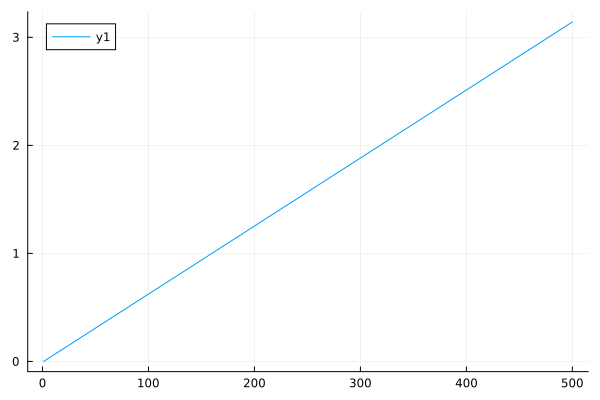

In [327]:
Plots.plot(times)

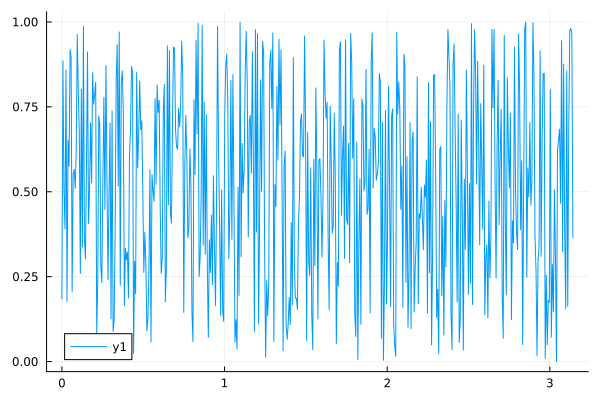

In [328]:
Plots.plot(times, phi')

In [330]:
# psi0 = get_bloch_state(system; lvl=0)
psi0 = QC.cavity_state(0, dim)
if system.params[:accelerated]
    append!(psi0, zeros(dim))
end

22-element Vector{ComplexF64}:
 1.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
     ⋮
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im

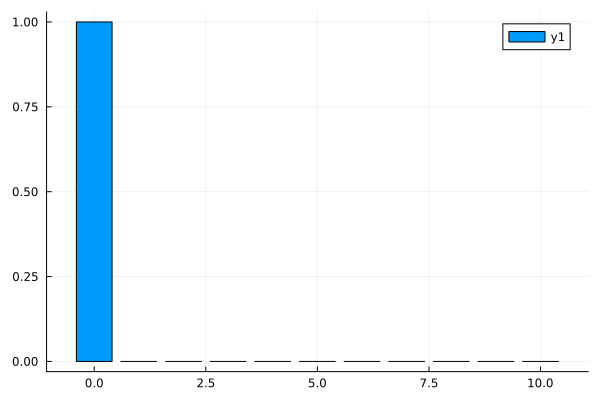

In [331]:
Plots.bar(0:dim-1, abs2.(psi0[1:dim]))

In [332]:
psi0_iso = QC.ket_to_iso(psi0)

44-element Vector{Float64}:
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [334]:
time_flight = 2pi * 0.001
T_flight = Int(round(time_flight/2pi*2000; digits=0))

2

In [338]:
#jumps = [(Z_split.T, time_flight), (Z_split.T+Z_mirror.T, time_flight)]
#jumps = [(div(T, 3), time_flight), (2*div(T, 3), time_flight)]
jumps = [(div(T, 2), time_flight)]
#jumps = Tuple{Int, Float64}[]
cuts = [jump[1] for jump in jumps]
full_times = get_times(dts, jumps)
G = get_shaken_lattice_propagator(system, times, jumps, T_flight)

1-element Vector{Matrix{Float64}}:
 [0.9999084954304516 1.4286307193915204e-20 … -0.0 -0.0; 1.112133997582206e-20 0.9997592430858332 … -0.0 -0.0; … ; 9.101946054272243e-9 4.5934467033425304e-9 … 0.808900376767226 -3.447960311313274e-16; -9.513451366960641e-10 4.394756695988669e-8 … -3.5071733966741387e-16 0.8089003767672237]

In [339]:
jumps

1-element Vector{Tuple{Int64, Float64}}:
 (250, 0.006283185307179587)

jumps = [(100, time_flight), (200, time_flight)]
#jumps = Tuple{Int, Float64}[]
cuts = [jump[1] for jump in jumps]
full_times = get_times(dts, jumps)
G = get_shaken_lattice_propagator(system, times, jumps, 10000)

In [340]:
G

1-element Vector{Matrix{Float64}}:
 [0.9999084954304516 1.4286307193915204e-20 … -0.0 -0.0; 1.112133997582206e-20 0.9997592430858332 … -0.0 -0.0; … ; 9.101946054272243e-9 4.5934467033425304e-9 … 0.808900376767226 -3.447960311313274e-16; -9.513451366960641e-10 4.394756695988669e-8 … -3.5071733966741387e-16 0.8089003767672237]

In [341]:
U = [QC.iso_vec_to_operator(QC.iso_operator_to_iso_vec(g)) for g in G]

1-element Vector{Matrix{ComplexF64}}:
 [0.9999084954304516 + 0.013527777570998984im 1.4286307193915204e-20 + 3.3951466884939204e-18im … 0.0 + 0.0im 0.0 + 0.0im; 1.112133997582206e-20 + 2.6429909477663835e-18im 0.9997592430858332 - 0.02194210255289795im … 0.0 + 0.0im 0.0 + 0.0im; … ; 2.8904774233199306e-9 + 9.101946054272243e-9im 1.5489300581210501e-9 + 4.5934467033425304e-9im … 0.808900376767226 - 0.5879457291841144im -3.447960311313274e-16 - 4.743731022198393e-16im; -3.0211579183269247e-10 - 9.513451366960641e-10im 1.4819309299038349e-8 + 4.394756695988669e-8im … -3.5071733966741387e-16 - 4.825196852598114e-16im 0.8089003767672237 - 0.5879457291841172im]

Plots.heatmap(sqrt.(abs.(U[1])), yflip=true)

Plots.heatmap(sqrt.(abs.(U[2])), yflip=true)

In [342]:
psi_iso = shaken_lattice_rollout(psi0_iso, a, dts, system, jumps, G)

44×500 Matrix{Float64}:
 1.0   0.999906     0.999629      0.999127     …   0.93075       0.933881
 0.0  -0.00350648  -0.0182854    -0.0275108        0.230798      0.220196
 0.0  -3.4648e-7   -6.29238e-5   -3.47335e-6       0.0868489     0.087522
 0.0  -0.0008164   -0.00424839   -0.00633972      -0.0140342    -0.0204063
 0.0   1.34025e-6   4.6559e-5     1.01748e-5      -0.0291467    -0.0315916
 0.0   5.33448e-5   0.000272587   0.000385565  …   0.00185341    0.0020251
 0.0   1.01119e-6   2.3584e-5     4.12632e-5      -0.0017118    -0.000890741
 0.0  -1.35134e-6  -6.36861e-6   -7.05798e-6       0.000256906   0.00014829
 0.0   1.02032e-7   2.228e-6      3.97751e-6       0.000314568   0.000203401
 0.0  -1.69114e-8  -5.49017e-8    9.49338e-9       5.64497e-6    1.01997e-5
 ⋮                                             ⋱                
 0.0   0.0          3.1323e-6     1.53363e-5   …  -0.994961     -0.940588
 0.0   0.0          9.58491e-6    2.85296e-5      -0.830347     -0.88729
 0.0   0.0 

In [343]:
psi_iso += rand(size(psi_iso)...)

44×500 Matrix{Float64}:
 1.14587    1.61223    1.36435    …   1.80889      1.7688      1.68415
 0.158369   0.568109   0.254569       0.641275     0.876015    0.315488
 0.387371   0.973223   0.887861       0.250331     0.922677    0.767437
 0.764981   0.297002   0.398265       0.263878     0.0562499   0.823205
 0.231804   0.295135   0.0376134      0.509112     0.657643    0.455976
 0.629392   0.164146   0.148278   …   0.798046     0.756242    0.20454
 0.54024    0.919223   0.229799       0.389675     0.405434    0.619296
 0.70682    0.809655   0.281941       0.93477      0.91224     0.871637
 0.564887   0.921404   0.912812       0.00680206   0.549886    0.596325
 0.608271   0.885186   0.631179       0.638613     0.256388    0.651922
 ⋮                                ⋱                           
 0.139428   0.959104   0.184977   …  -0.239838    -0.717407   -0.609325
 0.142925   0.652946   0.955467       0.00637861  -0.285164   -0.403463
 0.345204   0.615432   0.636861       0.518942     

psi_iso = QC.rollout(psi0_iso, a, dts, system)#; integrator=exp)

In [344]:
psi = hcat([QC.iso_to_ket(psi_iso[:,t]) for t=1:T]...)
pops = abs2.(psi)

22×500 Matrix{Float64}:
 2.0613     2.61176   2.00477    …   3.95924     3.39792    3.58776
 0.402697   0.334848  0.62265        1.19075     1.24312    0.895603
 0.262259   0.970306  0.883063       0.188872    0.890301   0.605654
 1.40421    0.14015   1.06997        0.0760173   0.36192    1.36709
 1.04978    0.820403  0.683177       1.11025     1.04774    0.806995
 1.06692    0.794462  0.0283529  …   0.802008    0.574339   0.437682
 0.712703   0.901452  0.588287       0.2658      0.168474   0.42052
 0.913315   0.983025  0.83885        1.39691     1.11201    1.23982
 0.374698   1.31024   0.862935       0.0354331   0.302376   0.612024
 0.452689   1.22824   1.37286        1.1559      0.127504   0.585019
 ⋮                               ⋱                         
 0.825755   1.24899   0.0456412      1.13661     0.965431   0.858097
 0.991957   0.676587  1.7974         1.22438     0.216749   0.730131
 0.595558   0.603052  0.486676   …  13.9785     15.3168    15.7207
 0.617645   0.604812  0.2

In [345]:
function format_plot(
    p,
    times=times,
    jumps=jumps,
    full_times=full_times,
)
    T = length(times)
    Plots.xticks!(p, (times[1:div(T,10):end], string.(round.(full_times[1:div(T,10):end]; digits=1))))
    Plots.xlims!(p, (times[1], times[end]))
    rel_y = 0.98
    for (cut, jump_time) in jumps
        rel_x = times[cut] / times[end]
        Plots.vline!(p, [times[cut]], color=:red, label=nothing)
        Plots.annotate!(((rel_x, rel_y), (string(round(jump_time; digits=1)), 10, :red)))
    end
    Plots.xlabel!(p, L"t \, [1/\omega_R]")
    return p
end

format_plot (generic function with 4 methods)

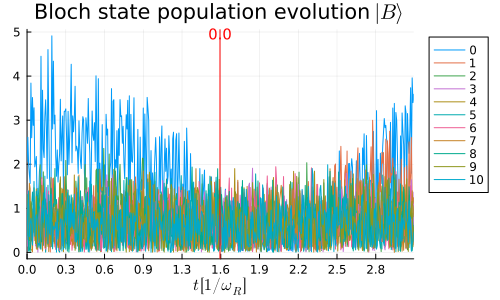

In [346]:
p = Plots.plot(times, pops[1:dim,:]', labels=(0:dim-1)', legend=:outertopright, size=(500,300))
Plots.plot!(
    p,
    title=L"Bloch state population evolution $|B\rangle$"
)
format_plot(p)

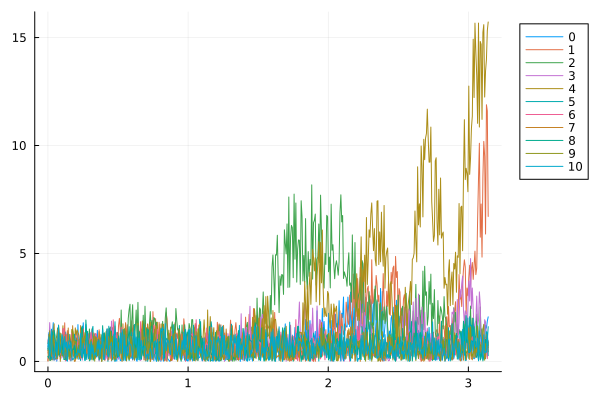

In [355]:
Plots.plot(times, pops[dim+1:end,:]', labels=(0:dim-1)', legend=:outertopright)

In [357]:
comps = (
    psi_iso = psi_iso,
    phi = phi,
    a = a,
    acc = acc,
    dts = dts
)
initial = (
    psi_iso = psi0_iso,
    phi = [0.],
    #da = da0
)
final = (;
    phi = [0.],
    #da = zeros(2)
)
goal = (;)
bounds = (
    # phi = phi_bound,
    dts = dt_bound,
)

Z_guess = nothing
GC.gc()
Z_guess = NT.NamedTrajectory(
    comps;
    controls=(:phi),
    timestep=:dts,
    bounds=bounds,
    initial=initial,
    final=final,
    goal=goal
)

NamedTrajectories.StructNamedTrajectory.NamedTrajectory{Float64}([1.145871710446674 1.6122347095602252 … 1.7688008927127752 1.684150983802105; 0.1583685169337068 0.5681088562560421 … 0.8760149469617352 0.31548844047981056; … ; 0.0 0.006295776860901389 … 3.1352968767288987 3.1415926535897998; 0.006295776860901389 0.006295776860901389 … 0.006295776860901389 0.006295776860901389], [1.145871710446674, 0.1583685169337068, 0.3873706360500391, 0.7649814229800371, 0.23180417180605095, 0.6293918668646867, 0.5402397953673431, 0.7068203939012129, 0.5648874263033721, 0.6082708034125206  …  0.7436420902221518, 0.785540493466306, 0.5774855962425949, 0.6630333407768095, 0.3727260837617266, 0.36528559655982784, 0.9340217795794369, 0.35721606244857174, 3.1415926535897998, 0.006295776860901389], 500, :dts, 49, (psi_iso = 44, phi = 1, a = 2, acc = 1, dts = 1, states = 48, controls = 1), (dts = ([0.006295776860901389], [0.006295776860901389]),), (psi_iso = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

Z_guess = copy(Z)

Z_guess = trajectory_shrink_extend(NT.load_traj("end2end/growing_trajectory/101.jld2"), 111)

Z_guess = NT.load_traj("end2end/growing_trajectory/101.jld2")

T = Z_guess.T
duration = 2pi*(T-1)/1000
psi_iso = Z_guess.psi_iso
phi = Z_guess.phi
a = Z_guess.a
dts = vec(Z_guess.dts)
full_times = get_times(dts, jumps)
times = full_times

pops_goal = abs2.(get_bloch_state(system; lvl=0))

dim = system.params[:dim]
J = NameComponentPathObjective(
    :psi_iso,
    1:dim,
    [T],
    [time -> pop for pop in pops_goal],
    [x -> abs2.(x) for _=1:dim],
    fill(1., dim, 1);
    is_iso=true
)

MZFI = (8pi*(duration/2)^2)^2

In [359]:
MZFI = (8pi*(full_times[end]/2)^2)^2

3845.4951224590905

In [360]:
function Fisher(psi, dpsi)
    psi = B*psi
    dpsi = B*dpsi
    eps = 0.0
    P = abs2.(psi)
    D = 2*real.(conj.(psi) .* dpsi)
    F = (1 ./ (P .+ eps))' * D.^2
    return F
end 


Fisher (generic function with 1 method)

In [361]:
function QFI(psi, dpsi)
    return 4*(real(dpsi'*dpsi) - abs2(dpsi'*psi))
end

QFI (generic function with 1 method)

In [362]:
fisher_loss = psi_dpsi -> -Fisher(psi_dpsi[1:dim], psi_dpsi[dim+1:2*dim]) / MZFI

#479 (generic function with 1 method)

In [363]:
qfi_loss = psidpsi -> -QFI(psidpsi[1:dim], psidpsi[dim+1:end])

#481 (generic function with 1 method)

In [364]:
log_sensitivity_loss = psi_dpsi -> -0.5 * log10(Fisher(psi_dpsi[1:dim], psi_dpsi[dim+1:2*dim])) + 0.5 * log10(MZFI)

#483 (generic function with 1 method)

In [365]:
log_qfi_sensitivity_loss = psi_dpsi -> -0.5 * log10(QFI(psi_dpsi[1:dim], psi_dpsi[dim+1:2*dim])) + 0.5 * log10(MZFI)

#485 (generic function with 1 method)

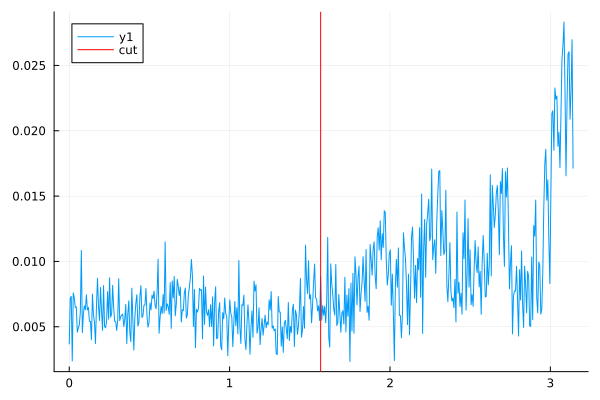

In [366]:
fisher_evol = [-fisher_loss(QC.iso_to_ket(psi_iso[:,t])) for t=1:T];
p = Plots.plot(times, fisher_evol)
Plots.vline!(p, times[cuts], color=:red, label="cut")

flight_times = 2pi * collect(1:40)

#fishers = []
for flight_time in flight_times
    println(flight_time)
    jumps = [(211, flight_time), (632, flight_time)]
    cuts = [jump[1] for jump in jumps]
    full_times = get_times(dts, jumps)
    G = get_shaken_lattice_propagator(system, times, jumps, 10000)
    psi_iso = shaken_lattice_rollout(psi0_iso, a, dts, system, jumps, G)
    push!(fishers, fisher_loss(psi_iso[:,end]))
end

In [369]:
Plots.plot(flight_times, hcat(-fishers, (4pi)^2 * flight_times.^4))

UndefVarError: UndefVarError: `flight_times` not defined

In [371]:
kernel = sinc_kernel(50., vec(Z_guess.dts))
convolver = LA.I(Z_guess.T) - kernel
convolver = convolver' * convolver

500×500 Matrix{Float64}:
  0.854618     -0.138052     -0.126402     …  -0.000943619  -0.00128135
 -0.138052      0.864331     -0.128816        -0.000550694  -0.000943619
 -0.126402     -0.128816      0.873112        -0.000120651  -0.000531191
 -0.111146     -0.117931     -0.120761         0.000305795  -8.34853e-5
 -0.0931956    -0.103682     -0.110833         0.00068862    0.000357033
 -0.0735929    -0.0869215    -0.0977159    …   0.00099233    0.000748942
 -0.0534412    -0.0686265    -0.0821993        0.00118934    0.00105583
 -0.0338272    -0.0498272    -0.0651903        0.00126256    0.00124978
 -0.0157497    -0.0315383    -0.0476509        0.001207      0.00131398
 -5.50858e-5   -0.0146914    -0.0305321        0.00103015    0.00124429
  ⋮                                        ⋱                
  0.00131398    0.001207      0.000996812     -0.0315383    -0.0157497
  0.00124978    0.00126256    0.00116271      -0.0498272    -0.0338272
  0.00105583    0.00118934    0.00121234      -0

In [372]:
#J = QC.QuantumObjective(name=:psi_iso, goals=QC.ket_to_iso(vcat(get_bloch_state(system; lvl=0), zeros(dim))), loss=:InfidelityLoss, Q=1e2)
#J = QC.QuantumObjective(name=:psi_iso, goals=QC.ket_to_iso(get_bloch_state(system; lvl=3)), loss=:InfidelityLoss, Q=1e2)

# J += NameComponentObjective(
#     :psi_iso,
#     [1:2*dim...],
#     [1:T...],
#     fisher_loss,
#     ([1:T...] ./ T).^2;
#     is_iso=true
# )

J1 = NameComponentObjective(
    :psi_iso,
    [1:2*dim...],
    [T],
    log_sensitivity_loss;
    is_iso=true
)

# convolution
J2 = QuadraticObjective(:phi, Z_guess, convolver, [1], 1:Z_guess.T; Q=50.0/T)

# encourage higher Bloch states
R = - [
    0., #0
    1., #1
    2., #2
    3., #3
    3., #4
    25., #5
    25., #6
    70., #7
    70., #8
    9., #9
    9., #10
] / T / 10.
J3 = NameComponentQuadraticRegularizer(:psi_iso, 1:dim, Z_guess, R; is_iso=true)

J = J1 + J2 #+ J3

QuantumCollocation.Objectives.Objective(QuantumCollocation.Objectives.var"#1#7"{QuantumCollocation.Objectives.Objective, QuantumCollocation.Objectives.Objective}(QuantumCollocation.Objectives.Objective(var"#L#125"{Symbol, Vector{Int64}, Vector{Float64}, var"#get_comp_idc_traj#124"{Bool, Vector{Int64}}}(:psi_iso, [500], [1.0], var"#get_comp_idc_traj#124"{Bool, Vector{Int64}}(true, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  13, 14, 15, 16, 17, 18, 19, 20, 21, 22]), Core.Box(var"#114#121"{var"#483#484"}(var"#483#484"()))), var"#∇L#126"{Symbol, Vector{Int64}, Vector{Float64}, var"#get_comp_idc_traj#124"{Bool, Vector{Int64}}, var"#115#122"}(:psi_iso, [500], [1.0], var"#get_comp_idc_traj#124"{Bool, Vector{Int64}}(true, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  13, 14, 15, 16, 17, 18, 19, 20, 21, 22]), var"#115#122"(Core.Box(var"#114#121"{var"#483#484"}(var"#483#484"())))), var"#∂²L#130"{var"#∂²L#119#131"{Symbol, Vector{Int64}, Vector{Float64}, var"#∂²L_structure#127"{Symbol, Vector{Int64}, var"#get_comp_id

In [373]:
J.L(Z_guess.datavec, Z_guess)

2.6396686562490905

In [374]:
J1.L(Z_guess.datavec, Z_guess)

0.8830125495695031

In [375]:
J2.L(Z_guess.datavec, Z_guess)

1.7566561066795874

In [376]:
J3.L(Z_guess.datavec, Z_guess)

-7.39598635258471

In [377]:
integrators = nothing
GC.gc()
integrators = [
    QC.QuantumStatePadeIntegrator(
        system,
        :psi_iso,
        (:a, :acc),
        :dts;
        order=4
    )
]

1-element Vector{QuantumCollocation.Integrators.QuantumStatePadeIntegrator{Float64}}:
 QuantumCollocation.Integrators.QuantumStatePadeIntegrator{Float64}(nothing, nothing, [1.1604477548756553 -3.817086743338521e-15 … 0.0 0.0; -3.817137565483579e-15 4.482431989861648 … 0.0 0.0; … ; 0.0 0.0 … 99.96841438887265 -4.762232631809572e-13; 0.0 0.0 … -4.746265189765724e-13 99.96841438886783], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [[-3.3135260969173914 3.2766992507114728e-15 … 0.0 0.0; 3.3964667131343313e-15 -0.9899576231226913 … 0.0 0.0; … ; 0.0 0.0 … 0.06315791627452493 5.695583959816801e-13; 0.0 0.0 … 5.695645302001018e-13 0.06315791627991879], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; -9.864038186824139e-7 -4.997744272231374e-7 … 0.0 0.0; 1.0309998214957898e-7 -4.781566332150105e-6 … 0.0 0.0]], [[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 

In [378]:
dynamics = QC.QuantumDynamics(
    integrators,
    Z_guess;
    cuts=cuts
)

QuantumCollocation.Dynamics.QuantumDynamics(QuantumCollocation.Integrators.QuantumStatePadeIntegrator{Float64}[QuantumCollocation.Integrators.QuantumStatePadeIntegrator{Float64}(nothing, nothing, [1.1604477548756553 -3.817086743338521e-15 … 0.0 0.0; -3.817137565483579e-15 4.482431989861648 … 0.0 0.0; … ; 0.0 0.0 … 99.96841438887265 -4.762232631809572e-13; 0.0 0.0 … -4.746265189765724e-13 99.96841438886783], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [[-3.3135260969173914 3.2766992507114728e-15 … 0.0 0.0; 3.3964667131343313e-15 -0.9899576231226913 … 0.0 0.0; … ; 0.0 0.0 … 0.06315791627452493 5.695583959816801e-13; 0.0 0.0 … 5.695645302001018e-13 0.06315791627991879], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; -9.864038186824139e-7 -4.997744272231374e-7 … 0.0 0.0; 1.0309998214957898e-7 -4.781566332150105e-6 … 0.0 0.0]], [[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0

In [379]:
constraints = [
    IQPhiConstraint(:a, :phi, Z_guess),
    vcat([get_link_constraints(
        :psi_iso, 
        Z_guess, 
        c, 
        g, 
        (; phi=[0.]), 
        (; phi=[0.]); 
        hard_equality_constraint=true)
        for (c, g) in zip(cuts, G)]...)...,
    TimeAffineLinearControlConstraint(:acc, 1, Z_guess; jumps=jumps),
    custom_bounds_constraint(:phi, Z_guess, vcat(cuts, cuts .+ 1), phi_bound)
    # NameComponentPathConstraint(
    #     :a,
    #     [3],
    #     Z_guess,
    #     [t -> t],
    #     [x -> x]
    # )
]

6-element Vector{QuantumCollocation.Constraints.AbstractConstraint}:
 QuantumCollocation.Constraints.NonlinearEqualityConstraint(var"#g#342"{var"#gQ#337", var"#gI#336", Vector{Int64}, Vector{Int64}, Vector{Int64}, Int64}(var"#gQ#337"(), var"#gI#336"(), [45, 94, 143, 192, 241, 290, 339, 388, 437, 486  …  24055, 24104, 24153, 24202, 24251, 24300, 24349, 24398, 24447, 24496], [47, 96, 145, 194, 243, 292, 341, 390, 439, 488  …  24057, 24106, 24155, 24204, 24253, 24302, 24351, 24400, 24449, 24498], [46, 95, 144, 193, 242, 291, 340, 389, 438, 487  …  24056, 24105, 24154, 24203, 24252, 24301, 24350, 24399, 24448, 24497], 500), var"#∂g#349"{var"#∂gQ#339", var"#∂gI#338", Vector{Int64}, Int64}(var"#∂gQ#339"(), var"#∂gI#338"(), [45, 94, 143, 192, 241, 290, 339, 388, 437, 486  …  24055, 24104, 24153, 24202, 24251, 24300, 24349, 24398, 24447, 24496], 500), [(1, 46), (1, 45), (2, 95), (2, 94), (3, 144), (3, 143), (4, 193), (4, 192), (5, 242), (5, 241)  …  (996, 24302), (996, 24300), (997, 24351), (9

In [381]:
# Ipopt options
options = QC.Options(
    max_iter=200,
)

QuantumCollocation.IpoptOptions.Options{Float64}(1.0e-8, 100.0, 200, 1.0e6, 1.0, 1.0e-12, 0.001, 1.0e-6, 15, 1.0e10, 0.01, 0.01, 1.0e-5, 1.0e8, 0.0001, 5, nothing, "no", "no", "no", "text", "no", "no", "original", 1, 0.0, "no", nothing, "mumps", 10, 3)

In [382]:
# defining quantum control problem
prob = nothing
GC.gc()
prob = QC.QuantumControlProblem(
    system, 
    Z_guess, 
    J, 
    dynamics;
    constraints=constraints,
    options=options,
)

applying constraint: initial value of psi_iso
applying constraint: initial value of phi
applying constraint: final value of phi
applying constraint: bounds on dts
applying constraint: linear vector link constraint
applying constraint: fix :phi before cut at t=250
applying constraint: fix :phi after cut at t=250
applying constraint: time affine linear control constraint
applying constraint: bounds on phi


QuantumCollocation.Problems.QuantumControlProblem(Ipopt.Optimizer, MathOptInterface.VariableIndex[MOI.VariableIndex(1) MOI.VariableIndex(50) … MOI.VariableIndex(24403) MOI.VariableIndex(24452); MOI.VariableIndex(2) MOI.VariableIndex(51) … MOI.VariableIndex(24404) MOI.VariableIndex(24453); … ; MOI.VariableIndex(48) MOI.VariableIndex(97) … MOI.VariableIndex(24450) MOI.VariableIndex(24499); MOI.VariableIndex(49) MOI.VariableIndex(98) … MOI.VariableIndex(24451) MOI.VariableIndex(24500)], QuantumCollocation.QuantumSystems.QuantumSystem{Float64}([1.1604477548756553 -3.817086743338521e-15 … 0.0 0.0; -3.817137565483579e-15 4.482431989861648 … 0.0 0.0; … ; 0.0 0.0 … 99.96841438887265 -4.762232631809572e-13; 0.0 0.0 … -4.746265189765724e-13 99.96841438886783], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [[-3.3135260969173914 3.2766992507114728e-15 … 0.0 0.0; 3.3964667131343313e-15 -0.9899576231226913 … 0.0 0.0; … ; 0.0 0.0 … 0.06315791627452493 5.69558395981

In [412]:
QC.solve!(prob)

This is Ipopt version 3.14.13, running with linear solver MUMPS 5.6.0.

Number of nonzeros in equality constraint Jacobian...:  1503508
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:   234192

Total number of variables............................:    23952
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      496
                     variables with only upper bounds:        0
Total number of equality constraints.................:    23456
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.4630712e-01 1.01e-03 3.05e-03  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

   1 -1.4453537e-01 3.04e-03 2.62e-01  -1.0 1.97e-01  -2.0 9.99e-01 1.00e+00f  1


   2 -1.4226920e-01 2.60e-02 8.32e-01  -1.7 4.16e-01  -2.5 1.00e+00 1.00e+00h  1


   3 -1.1593900e-01 5.25e-01 7.97e-02  -1.7 1.05e+00  -3.0 1.00e+00 1.00e+00h  1


   4 -1.0613563e-01 3.07e-01 1.07e-01  -1.7 1.23e+00  -3.4 1.00e+00 1.00e+00h  1


   5 -1.5703077e-02 1.43e-01 5.70e-01  -1.7 3.64e+00  -3.9 1.00e+00 1.00e+00h  1


   6 -4.3090291e-02 7.09e-03 2.69e+00  -1.7 3.94e-01  -1.7 1.00e+00 1.00e+00h  1


   7 -8.2826764e-02 3.26e-01 3.24e+00  -1.7 2.11e+01  -2.2 2.31e-01 6.31e-02h  3


   8 -9.7720422e-02 4.57e-01 4.50e-01  -1.7 9.98e-01  -2.6 1.00e+00 1.00e+00h  1


   9 -4.2706443e-02 1.10e-01 1.38e+00  -1.7 9.16e-01  -3.1 1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 -4.6891171e-02 2.38e-01 2.32e+00  -1.7 4.68e+00  -2.7 1.00e+00 5.00e-01h  2


  11 -6.3530868e-02 4.21e-02 2.62e-02  -1.7 5.65e-01  -2.3 1.00e+00 1.00e+00h  1


  12 -1.0693804e-01 1.20e-02 2.02e-01  -2.5 4.73e-01  -2.7 1.00e+00 1.00e+00h  1


  13 -1.2136105e-01 1.72e-02 5.85e-01  -2.5 4.19e-01  -3.2 1.00e+00 1.00e+00h  1


  14 -1.0668276e-01 2.36e-03 1.23e+00  -2.5 9.55e-01  -3.7 1.00e+00 1.00e+00H  1


  15 -1.2556935e-01 2.19e-02 5.94e-01  -2.5 5.57e-01  -2.4 1.00e+00 1.00e+00h  1


  16 -1.2730670e-01 4.35e-03 3.75e-03  -2.5 1.02e-01  -2.8 1.00e+00 1.00e+00h  1


  17 -1.3068884e-01 2.52e-03 1.96e-02  -3.8 1.26e-01  -3.3 1.00e+00 1.00e+00h  1


  18 -1.3594426e-01 1.03e-02 1.04e-02  -3.8 3.09e-01  -3.8 1.00e+00 1.00e+00h  1


  19 -1.4608952e-01 1.53e-01 6.35e-03  -3.8 7.42e-01  -4.3 1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -1.5605560e-01 3.86e-01 7.87e-03  -3.8 1.03e+00  -4.7 1.00e+00 1.00e+00h  1


  21 -1.6136692e-01 4.45e-02 3.24e-03  -3.8 1.03e+00  -5.2 1.00e+00 1.00e+00h  1


  22 -1.6264827e-01 5.91e-02 6.46e-02  -3.8 9.93e-01  -5.7 1.00e+00 1.00e+00h  1


  23 -1.5413522e-01 3.73e-02 8.82e-01  -3.8 5.49e+00  -5.3 1.00e+00 1.00e+00H  1


  24 -1.5742062e-01 3.48e-03 6.02e-01  -3.8 1.60e-01  -2.1 1.00e+00 1.00e+00h  1


  25 -1.5799450e-01 1.69e-03 2.42e-02  -3.8 8.44e-02  -2.6 1.00e+00 1.00e+00h  1


  26 -1.5825727e-01 1.84e-04 1.87e-03  -3.8 1.02e-01  -3.1 1.00e+00 1.00e+00h  1


  27 -1.5872062e-01 7.72e-04 4.80e-03  -3.8 1.74e-01  -3.6 1.00e+00 1.00e+00h  1


  28 -1.5948577e-01 2.03e-03 6.38e-03  -3.8 2.95e-01  -4.0 1.00e+00 1.00e+00h  1


  29 -1.6053765e-01 5.96e-03 7.07e-03  -3.8 5.81e-01  -4.5 1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -1.6187711e-01 4.86e-02 7.21e-03  -3.8 9.06e-01  -5.0 1.00e+00 1.00e+00h  1


  31 -1.6330039e-01 5.33e-02 1.72e-02  -3.8 1.38e+00  -5.5 1.00e+00 1.00e+00h  1


  32 -1.6371303e-01 1.91e-02 1.63e-02  -3.8 1.12e+00  -6.0 1.00e+00 1.00e+00h  1


  33 -1.6123168e-01 2.61e-03 2.50e-01  -3.8 5.43e-01  -5.5 1.00e+00 1.00e+00h  1


  34 -1.6299695e-01 2.81e-04 4.59e-01  -3.8 7.78e-02  -2.4 1.00e+00 1.00e+00h  1


  35 -1.6321377e-01 2.41e-04 3.45e-01  -3.8 6.51e-02  -2.9 1.00e+00 1.00e+00h  1


  36 -1.6145210e-01 4.44e-05 3.45e-01  -3.8 3.98e-01  -3.3 1.00e+00 1.00e+00H  1


  37 -1.6238871e-01 4.40e-06 2.82e-02  -3.8 6.91e-02  -2.9 1.00e+00 1.00e+00H  1


  38 -1.6310512e-01 4.59e-04 9.41e-02  -3.8 1.05e-01  -3.4 1.00e+00 1.00e+00h  1


  39 -1.6316685e-01 2.88e-04 6.23e-03  -3.8 9.84e-02  -3.9 1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 -1.6325187e-01 2.24e-04 2.02e-03  -3.8 8.49e-02  -4.4 1.00e+00 1.00e+00h  1


  41 -1.6334833e-01 5.61e-04 6.40e-02  -3.8 1.02e-01  -4.8 1.00e+00 1.00e+00h  1


  42 -1.6358173e-01 4.88e-03 1.04e-02  -3.8 4.28e+00  -5.3 1.00e+00 2.50e-01h  3


  43 -1.6375969e-01 8.47e-03 2.47e-02  -3.8 8.12e-01  -5.8 1.00e+00 1.00e+00h  1


  44 -1.6339559e-01 3.48e-03 2.81e-01  -3.8 5.13e-01  -5.4 1.00e+00 1.00e+00h  1


  45 -1.6356465e-01 3.05e-03 5.51e-02  -3.8 2.54e-01  -3.1 1.00e+00 1.25e-01h  4


  46 -1.6353255e-01 6.96e-06 6.41e-04  -3.8 8.47e-03  -3.6 1.00e+00 1.00e+00h  1


  47 -1.6372231e-01 6.25e-06 3.17e-03  -4.0 3.32e-02  -4.1 1.00e+00 1.00e+00H  1


  48 -1.6390628e-01 4.88e-06 6.33e-03  -4.0 5.47e-02  -4.6 1.00e+00 1.00e+00H  1


  49 -1.6414460e-01 1.09e-06 7.54e-03  -4.0 1.13e-01  -5.0 1.00e+00 1.00e+00H  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 -1.6447512e-01 4.56e-06 6.29e-03  -4.0 2.94e-01  -5.5 1.00e+00 1.00e+00H  1


  51 -1.6487857e-01 5.65e-06 5.22e-03  -4.0 7.23e-01  -6.0 1.00e+00 1.00e+00H  1


  52 -1.8021916e-01 3.81e-01 2.86e-01  -4.0 2.68e+01    -  4.29e-01 3.54e-01h  1


  53 -1.7607684e-01 2.92e-01 2.72e-01  -4.0 8.97e-01  -2.9 1.00e+00 2.47e-01h  1


  54 -1.7139601e-01 2.30e-01 1.40e-01  -4.0 8.70e-01  -3.3 1.00e+00 2.12e-01h  2


  55 -1.6779324e-01 1.73e-01 6.25e-02  -4.0 9.35e-01  -3.8 1.00e+00 2.50e-01h  3


  56 -1.6637970e-01 1.30e-01 2.24e-01  -4.0 9.35e-01  -4.3 1.00e+00 2.50e-01h  3


  57 -1.6635407e-01 1.30e-01 2.23e-01  -4.0 6.19e-01  -3.9 1.00e+00 3.91e-03h  9


  58 -1.6635149e-01 1.30e-01 2.23e-01  -4.0 5.00e-01  -3.4 1.00e+00 2.44e-04h 13


  59 -1.6000617e-01 1.16e-02 2.12e-02  -4.0 6.29e-01  -3.9 1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 -1.6386240e-01 8.44e-03 3.86e-02  -4.0 2.85e-01  -4.4 9.74e-01 1.00e+00h  1


  61 -1.6642780e-01 6.33e-02 4.24e-02  -4.0 1.82e+00    -  5.66e-01 1.00e+00h  1


  62 -1.6538656e-01 1.44e-03 1.08e-03  -4.0 9.05e-02  -4.0 1.00e+00 1.00e+00h  1


  63 -1.6548289e-01 4.90e-04 5.64e-02  -4.0 2.13e-01  -4.4 1.00e+00 1.00e+00h  1


  64 -1.7381374e-01 2.73e-01 3.68e-01  -4.0 7.30e+00    -  8.30e-01 1.00e+00H  1


  65 -1.6980083e-01 1.41e-01 6.84e-02  -4.0 9.57e-01  -3.1 1.00e+00 5.00e-01h  2


  66 -1.6721759e-01 7.10e-02 4.24e-02  -4.0 4.85e-01  -3.6 1.00e+00 5.00e-01h  2


  67 -1.6591075e-01 3.55e-02 2.52e-02  -4.0 3.14e-01  -4.1 1.00e+00 5.00e-01h  2


  68 -1.6536534e-01 1.80e-02 1.31e-02  -4.0 3.02e-01  -4.5 1.00e+00 5.00e-01h  2


  69 -1.6500268e-01 2.78e-03 1.75e-03  -4.0 3.13e-01  -5.0 1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -1.6522598e-01 1.49e-03 1.18e-03  -4.0 3.70e-01  -5.5 1.00e+00 1.00e+00h  1


  71 -1.6540182e-01 1.17e-02 1.01e-03  -4.0 5.28e-01  -6.0 1.00e+00 1.00e+00h  1


  72 -1.8216481e-01 1.41e-01 1.64e-01  -4.0 1.13e+01    -  1.00e+00 1.00e+00h  1


  73 -1.7353594e-01 9.79e-02 7.94e-02  -4.0 9.12e-01  -3.7 1.00e+00 4.14e-01h  1


  74 -1.7165464e-01 8.57e-02 7.10e-02  -4.0 1.33e+00  -4.2 1.00e+00 1.25e-01h  4


  75 -1.7075057e-01 7.50e-02 6.31e-02  -4.0 1.65e+00  -4.7 1.00e+00 1.25e-01h  4


  76 -1.7131479e-01 7.29e-02 9.61e-02  -4.0 1.94e+01  -5.2 2.85e-01 3.12e-02h  6


  77 -1.6881421e-01 1.31e-01 4.79e-02  -4.0 1.91e+00  -5.6 2.11e-01 5.00e-01h  2


  78 -1.6567861e-01 1.12e-02 5.93e-03  -4.0 1.18e+00  -6.1 1.00e+00 1.00e+00h  1


  79 -1.6818878e-01 6.48e-02 8.33e-03  -4.0 3.29e+00    -  1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -1.6543166e-01 2.62e-03 1.53e-02  -4.0 2.25e-01  -4.8 1.00e+00 1.00e+00h  1


  81 -1.6561457e-01 1.46e-02 1.19e-01  -4.0 7.43e-01    -  1.00e+00 1.00e+00h  1


  82 -1.6539439e-01 3.95e-04 2.06e-01  -4.0 1.26e-01  -3.5 1.00e+00 1.00e+00h  1


  83 -1.6542328e-01 1.70e-05 6.15e-03  -4.0 1.89e-02  -3.0 1.00e+00 1.00e+00h  1


  84 -1.6547742e-01 2.58e-05 2.87e-02  -4.0 4.09e-02  -3.5 1.00e+00 1.00e+00h  1


  85 -1.6549480e-01 1.02e-05 6.12e-03  -4.0 1.82e-02  -4.0 1.00e+00 1.00e+00h  1


  86 -1.6570384e-01 1.75e-03 4.14e-02  -4.0 9.09e-01    -  1.00e+00 1.00e+00h  1


  87 -1.6564231e-01 1.36e-03 3.47e-01  -4.0 1.53e-01  -4.5 1.00e+00 2.50e-01h  3


  88 -1.6554339e-01 1.09e-05 7.32e-01  -4.0 1.16e-02  -2.2 1.00e+00 1.00e+00h  1


  89 -1.6558629e-01 1.85e-06 7.08e-01  -4.0 5.80e-03  -1.8 1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 -1.6553863e-01 1.66e-06 1.38e+00  -4.0 5.55e-03  -2.3 1.00e+00 1.00e+00h  1


  91 -1.6554432e-01 4.62e-07 3.20e+00  -4.0 3.30e-03  -1.0 1.00e+00 1.00e+00h  1


  92 -1.6559838e-01 6.59e-08 1.19e+00  -4.0 1.22e-03  -0.5 1.00e+00 1.00e+00h  1


  93 -1.6559932e-01 7.04e-09 1.51e-02  -4.0 1.64e-04  -1.0 1.00e+00 1.00e+00h  1


  94 -1.6559937e-01 2.96e-08 1.84e-03  -4.0 2.79e-04  -1.5 1.00e+00 1.00e+00h  1


  95 -1.6560434e-01 3.96e-04 7.80e-04  -4.0 1.61e-01    -  1.00e+00 1.00e+00h  1


  96 -1.6559774e-01 7.87e-08 4.37e-06  -4.0 4.05e-04  -2.0 1.00e+00 1.00e+00h  1


  97 -1.6559531e-01 8.27e-06 1.27e-03  -4.0 3.65e-02    -  1.00e+00 1.00e+00h  1


  98 -1.6559465e-01 6.33e-07 9.54e-05  -4.0 4.33e-02    -  1.00e+00 1.00e+00H  1


  99 -1.6559463e-01 1.01e-10 1.37e-08  -4.0 3.80e-06  -2.4 1.00e+00 1.00e+00h  1


iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -1.6559463e-01 7.97e-11 6.23e-09  -4.0 5.20e-06  -2.9 1.00e+00 1.00e+00h  1


 101 -1.6559467e-01 1.49e-08 2.51e-06  -4.0 1.95e-03    -  1.00e+00 1.00e+00h  1


 102 -1.6559467e-01 8.40e-12 1.12e-10  -4.0 2.81e-07  -3.4 1.00e+00 1.00e+00h  1


 103 -1.6559467e-01 1.23e-10 3.63e-11  -4.0 9.75e-06    -  1.00e+00 1.00e+00h  1


 104 -1.6559467e-01 1.52e-12 8.81e-13  -4.0 9.85e-08    -  1.00e+00 1.00e+00h  1


 105 -1.6559467e-01 1.82e-13 3.25e-14  -4.0 2.59e-08    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 105

                                   (scaled)                 (unscaled)
Objective...............:  -1.6559467427203320e-01   -1.6559467427203320e-01
Dual infeasibility......:   3.2547522533397694e-14    3.2547522533397694e-14
Constraint violation....:   1.8232637621906633e-13    1.8232637621906633e-13
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.0000000000000014e-04    1.0000000000000014e-04
Overall NLP error.......:   1.8232637621906633e-13    1.8232637621906633e-13


Number of objective function evaluations             = 184
Number of objective gradient evaluations             = 106
Number of equality constraint evaluations            = 184
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 106
Number of inequality constraint Jacobian evaluations = 0
Nu

In [411]:
Z_guess = NT.copy(Z)

NamedTrajectories.StructNamedTrajectory.NamedTrajectory{Float64}([1.0 0.9999081283168132 … 0.12513437705983166 0.12442503863557094; 0.0 8.48207120642245e-21 … 0.7635297457082032 0.7609140388217307; … ; -1.1633173997113217e-25 0.006295776860901389 … 3.1352842851751914 3.141580062036093; 0.006295776860901389 0.006295776860901389 … 0.006295776860901389 0.006295776860901389], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.1802320568674876, -0.3533166342423539, -0.9619398568065288, -0.18775959866284497, -0.01627617102238116, 0.0, 1.0, 0.0, 3.141580062036093, 0.006295776860901389], 500, :dts, 49, (psi_iso = 44, phi = 1, a = 2, acc = 1, dts = 1, states = 48, controls = 1), (dts = ([0.006295776860901389], [0.006295776860901389]),), (psi_iso = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], phi = [0.0]), (phi = [0.0],), NamedTuple(), (psi_iso = 1:44, phi = 45:45, a = 46:47, acc = 48:48, dts = 49:49, states = [1, 2, 3, 4, 5, 6, 7,

In [413]:
Z = prob.trajectory

NamedTrajectories.StructNamedTrajectory.NamedTrajectory{Float64}([1.0 0.9999081283168132 … 0.2668276097677559 0.26143442638363334; 0.0 3.9980261719145855e-21 … 0.327439040370656 0.32860510516743396; … ; 1.6889134852673154e-23 0.006295776860901389 … 3.1352842851751914 3.141580062036093; 0.006295776860901389 0.006295776860901389 … 0.006295776860901389 0.006295776860901389], [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  -5.059162956436302, -2.0331792824966692, 2.668153702455243, 1.1420367136844103, -2.151613935253781, 0.0, 1.0, 0.0, 3.141580062036093, 0.006295776860901389], 500, :dts, 49, (psi_iso = 44, phi = 1, a = 2, acc = 1, dts = 1, states = 48, controls = 1), (dts = ([0.006295776860901389], [0.006295776860901389]),), (psi_iso = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], phi = [0.0]), (phi = [0.0],), NamedTuple(), (psi_iso = 1:44, phi = 45:45, a = 46:47, acc = 48:48, dts = 49:49, states = [1, 2, 3, 4, 5, 6, 7, 8, 9,

In [414]:
J1.L(Z.datavec, Z)

-0.16718027140178426

In [415]:
J2.L(Z.datavec, Z)

0.0015855971297510625

In [416]:
J3.L(Z.datavec, Z)

-0.2657802127535996

In [417]:
Z.psi_iso

44×500 Matrix{Float64}:
 1.0   0.999908      0.999638     …   0.272112    0.266828    0.261434
 0.0   3.99803e-21  -0.00465126       0.326234    0.327439    0.328605
 0.0  -3.07807e-19  -5.58009e-6       0.64871     0.660987    0.672444
 0.0   2.61474e-19  -0.00108364       0.120165    0.103341    0.0853803
 0.0  -4.61755e-19   4.0634e-6       -0.116282   -0.0979119  -0.0784718
 0.0   1.11384e-19   7.08859e-5   …   0.0350181   0.0275241   0.0186739
 0.0  -4.91401e-20   1.87254e-6       0.0397437   0.0329017   0.0244263
 0.0  -4.12771e-21  -1.79705e-6       0.0168572   0.0222938   0.0241612
 0.0   3.43688e-21   1.77915e-7      -0.0185297  -0.0221634  -0.0222531
 0.0  -5.06583e-20  -2.22916e-8      -0.0183576  -0.0196829  -0.0134589
 ⋮                                ⋱                          
 0.0  -6.08614e-23   7.25344e-7   …  -1.73611    -1.67332    -1.61034
 0.0   9.02529e-22   9.59033e-6      -1.57049    -0.0224811   1.53428
 0.0  -6.51829e-22  -6.13473e-7       3.36235     1.61322

In [418]:
#psi_iso_rollout = QC.rollout(psi0_iso, vcat(Z.a, Z.acc'), dts, system; integrator=exp)
#psi_iso_rollout = Z.psi_iso
psi_iso_rollout = shaken_lattice_rollout(psi0_iso, Z.a, vec(Z.dts), system, jumps, G)#; integrator=exp)
psi = hcat([QC.iso_to_ket(psi_iso_rollout[:,t]) for t=1:T]...)
pops = abs2.(psi)

22×500 Matrix{Float64}:
 1.0  1.0          0.999977     0.999857     …    0.245154       0.245333
 0.0  7.01355e-36  2.16352e-5   0.000134228       0.114291       0.113836
 0.0  7.81542e-34  1.37634e-7   1.46901e-6        0.547926       0.548156
 0.0  4.36588e-35  1.1752e-6    7.27218e-6        0.0413876      0.0414256
 0.0  1.09804e-34  1.76419e-8   1.89637e-7        0.0448629      0.0448972
 0.0  1.05605e-36  5.07204e-9   3.11624e-8   …    0.00204163     0.00202916
 0.0  1.53837e-37  8.45227e-11  1.10326e-9        0.00221255     0.00220015
 0.0  8.70085e-43  3.37107e-12  2.07976e-11       0.000583652    0.000583507
 0.0  1.88084e-39  1.02015e-13  2.49852e-12       0.000511696    0.000511733
 0.0  1.99439e-42  5.67141e-16  3.58368e-15       0.000405855    0.000405402
 ⋮                                           ⋱                 
 0.0  0.0          5.2611e-13   3.14676e-11      11.8225        11.7643
 0.0  0.0          9.20909e-11  8.2879e-10      246.165        247.337
 0.0  0.0     

In [420]:
function format_plot(
    p,
    times=times,
    jumps=jumps,
    full_times=full_times,
)
    T = length(times)
    Plots.xticks!(p, (times[1:div(T,10):end], string.(round.(full_times[1:div(T,10):end]; digits=1))))
    Plots.xlims!(p, (times[1], times[end]))
    rel_y = 0.98
    for (cut, jump_time) in jumps
        rel_x = times[cut] / times[end]
        Plots.vline!(p, [times[cut]], color=:red, label=nothing)
        Plots.annotate!(((rel_x, rel_y), (string(round(jump_time; digits=1)), 10, :red)))
    end
    Plots.xlabel!(p, L"t \, [1/\omega_R]")
    return p
end

format_plot (generic function with 4 methods)

In [421]:
pops_p = abs2.(B2 * psi)
dim_p = div(size(pops_p, 1), 2)
p_max = div(dim_p, 2)

11

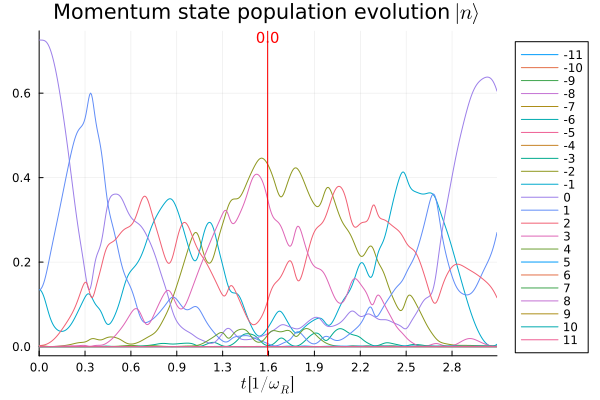

In [422]:
p = Plots.plot(times, pops_p[1:dim_p,:]', labels=(-p_max:p_max)', legend=:outertopright)
Plots.plot!(
    p,
    title=L"Momentum state population evolution $|n\rangle$"
)
format_plot(p)

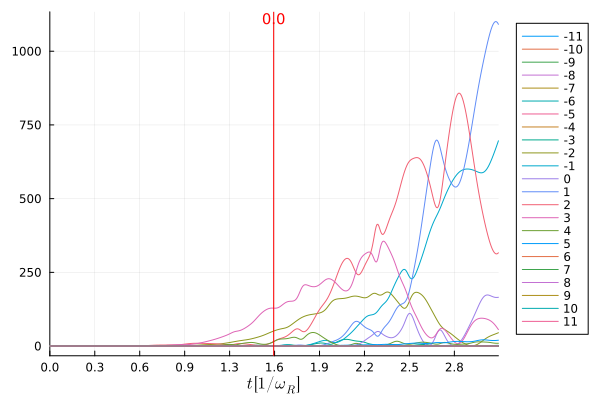

In [423]:
p = Plots.plot(times, pops_p[dim_p+1:end,:]', labels=(-p_max:p_max)', legend=:outertopright)
format_plot(p)

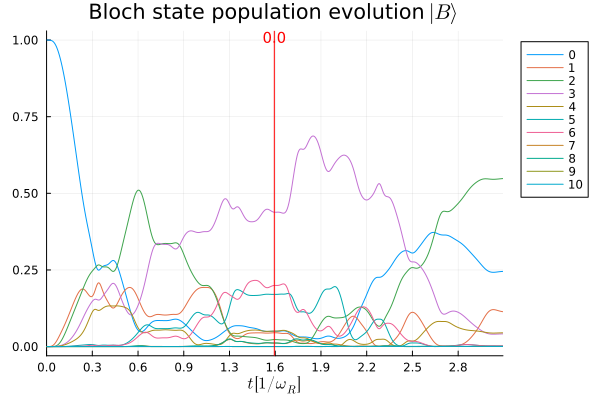

In [425]:
p = Plots.plot(times, pops[1:dim,:]', labels=(0:dim-1)', legend=:outertopright)
Plots.plot!(
    p,
    title=L"Bloch state population evolution $|B\rangle$"
)
format_plot(p)

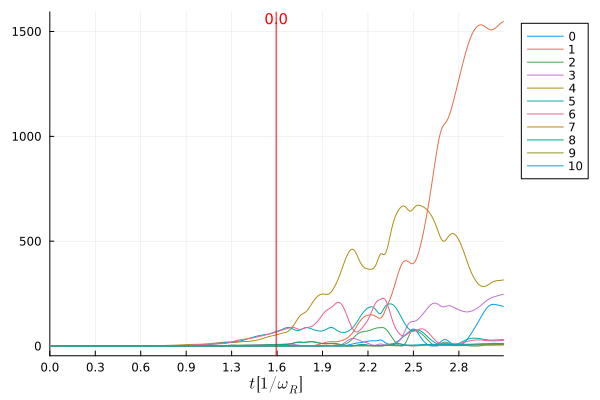

In [427]:
p = Plots.plot(times, pops[dim+1:end,:]', labels=(0:dim-1)', legend=:outertopright)
format_plot(p)

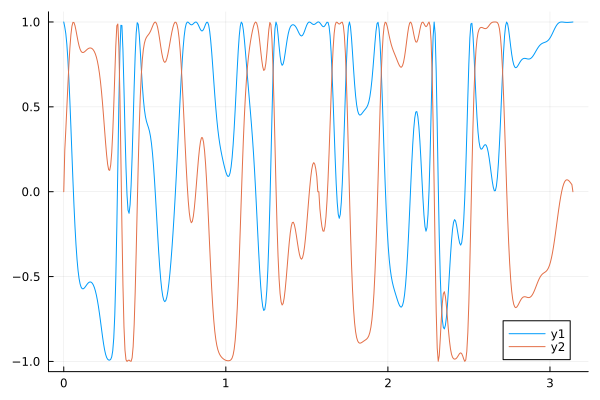

In [428]:
Plots.plot(times, Z.a')

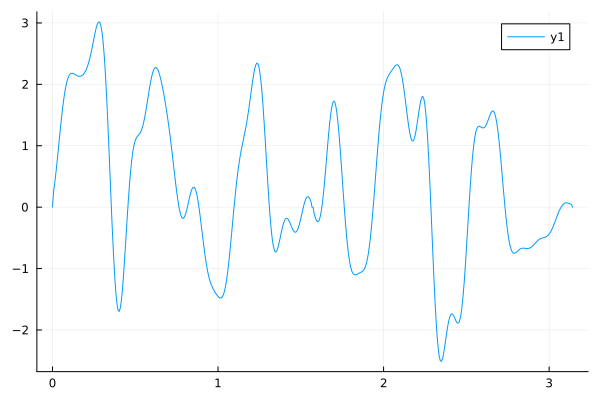

In [429]:
Plots.plot(times, Z.phi')

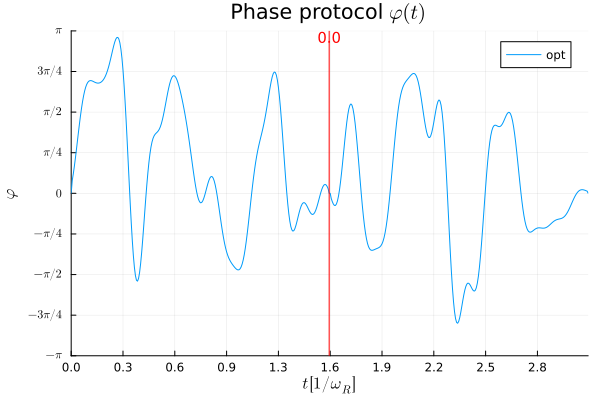

In [430]:
pi_ticks = LinRange(-pi, pi, 9)
pi_lbls = [L"-\pi", L"-3\pi/4", L"-\pi/2", L"-\pi/4", L"0", L"\pi/4", L"\pi/2", L"3\pi/4", L"\pi"]
p = Plots.plot(times, Z.phi', ylim=(-pi, pi), yticks=(pi_ticks, pi_lbls), label="opt")
# Plots.plot!(p, times, phi_guess, alpha=0.5, label="guess")
format_plot(p)
Plots.plot!(
    p,
    title=L"Phase protocol $\varphi(t)$",
    ylabel=L"\varphi"
)

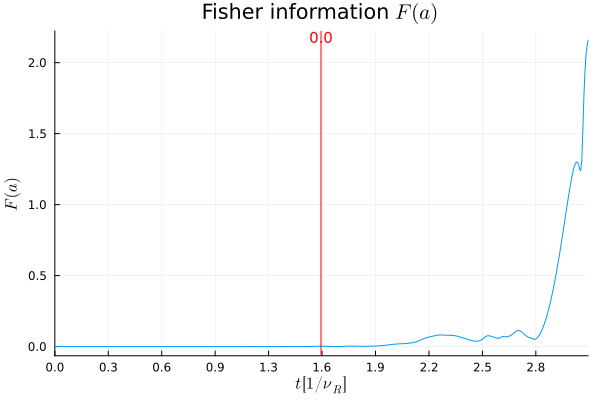

In [431]:
fisher_evol = [-fisher_loss(QC.iso_to_ket(psi_iso_rollout[:,t])) for t=1:T];
p = Plots.plot(times, fisher_evol, label=nothing)
format_plot(p)
Plots.plot!(
    p,
    title=L"Fisher information $F(a)$",
    xlabel=L"t \, [1/\nu_R]",
    ylabel=L"F(a)"
)

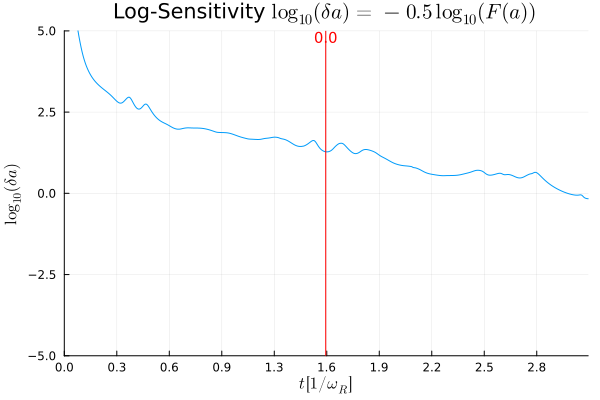

In [432]:
log_sensitivity_evol = [log_sensitivity_loss(QC.iso_to_ket(psi_iso_rollout[:,t])) for t=1:T]
p = Plots.plot(times[2:end], log_sensitivity_evol[2:end], ylim=(-5., 5.), label=nothing)
format_plot(p)
Plots.plot!(
    p,
    title=L"Log-Sensitivity $\log_{10}(\delta a) = -0.5 \, \log_{10}(F(a))$",
    ylabel=L"\log_{10}(\delta a)"
)

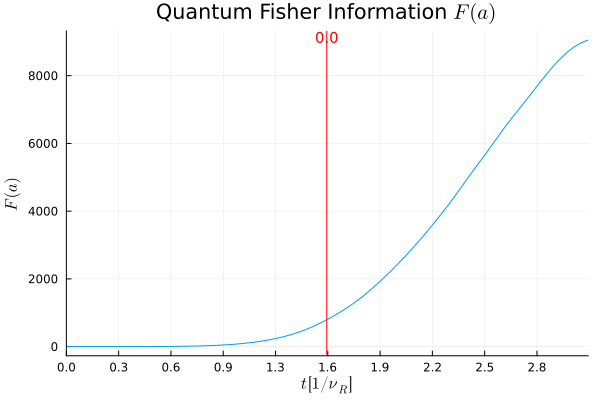

In [433]:
qfi_evol = [-qfi_loss(QC.iso_to_ket(psi_iso_rollout[:,t])) for t=1:T];
p = Plots.plot(times, qfi_evol, label=nothing)
format_plot(p)
Plots.plot!(
    p,
    title=L"Quantum Fisher Information $F(a)$",
    xlabel=L"t \, [1/\nu_R]",
    ylabel=L"F(a)"
)

In [407]:
F = fisher_evol[end]
F, 1/sqrt(F)

(2.1331181199231963, 0.6846877338420626)

In [434]:
#freqs = collect(12.464:0.001:12.468)
freqs = collect(0.:0.1:60.0)
phi_ft = fourier_time_freq(Z.phi', times, freqs/2pi);

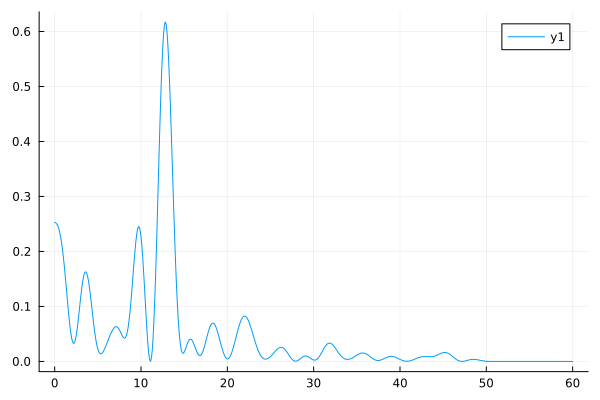

In [435]:
Plots.plot(freqs, abs2.(phi_ft))#, ylims=(0.000895, 0.0009))

In [437]:
import JLD2

In [ ]:
jumps

In [438]:
JLD2.save("./end2end/growing_free_prop/0.001.jld2", Z)

In [454]:
s = """
Flight time (in ωᵣ/2pi):
$(time_flight/2pi)
MZFI (+-4k_L split):
$MZFI
Final CFI (normalized to MZFI):
$(-fisher_loss(QC.iso_to_ket(Z.psi_iso[:,end])))
Final log10(δa):
$(J1.L(Z.datavec, Z))
"""
write("0.001.txt", s)

164

### Fisher range over a

In [ ]:
acc_range = LinRange(-0.001, 0.001, 81)

In [ ]:
fisher_vals = []

In [ ]:
jumps

In [ ]:
for acc_val in acc_range
    println(acc_val)
    system = ShakenLatticeSystem1D(V, p_max; acc=acc_val, include_acc_derivative=true)
    psi_iso_final = shaken_lattice_rollout(psi0_iso, Z.a, dts, system, jumps, 10000; integrator=exp)[:,end]
    push!(fisher_vals, -fisher_loss(psi_iso_final))
end


In [ ]:
Plots.plot(acc_range, fisher_vals/MZFI)

In [ ]:
jumps

In [ ]:
a_full, dts_full = get_controls_dts(Z.a, vec(Z.dts), jumps, 10000)

In [ ]:
phi_full = angle.(a_full[1,:] + im*a_full[2,:])
times_full = cumsum(dts_full) - dts_full

In [ ]:
Plots.plot(times_full, phi_full)

In [ ]:
psi_iso_full = shaken_lattice_rollout(psi0_iso, Z.a, vec(Z.dts), system, jumps, 10000)

In [ ]:
T_full = length(dts_full)

In [ ]:
psi_full = hcat([QC.iso_to_ket(psi_iso_full[:,t]) for t=1:T_full]...)
pops_full = abs2.(psi_full)

In [ ]:
psi_bloch_full = bloch_states' * psi_full[1:dim,:]
pops_bloch_full = abs2.(psi_bloch_full)

In [ ]:
Plots.plot(times_full, pops_full[1:dim,:]')

In [ ]:
Plots.plot(times_full, pops_full[dim+1:end,:]')

In [ ]:
Plots.plot(times_full, pops_bloch_full', label=(0:8)', legend=:outertopright)

In [ ]:
p = Plots.plot(times, pops_bloch', labels=(0:dim-1)', legend=:outertopright)
Plots.plot!(
    p,
    title=L"Bloch state population evolution $|b\rangle$"
)
format_plot(p)

Z_save = copy(Z)
Z_guess = Z_save

## roll out repetition

In [ ]:
function get_repeated_controls(a::AbstractMatrix, dts::AbstractVector, N::Int)
    T = length(dts)
    dts_long = repeat(dts, N)
    a_long = repeat(a, 1, N)
    times_long = cumsum(dts_long) - dts_long
    for n=2:N
        a_long[3,(n-1)*T+1:n*T] .+= (n-1)*times_long[T]
    end 
    return (a_long, dts_long, times_long)
end
function get_repeated_controls(Z::NT.NamedTrajectory, N::Int)
    return get_repeated_controls(Z.a, vec(Z.dts), N)
end

function get_repeated_controls_alternated(a::AbstractMatrix, dts::AbstractVector, N::Int)
    T = length(dts)
    dts_long = repeat(dts, N)
    a_long = repeat(a, 1, N)
    for n=2:2:N
        a_long[1:2,(n-1)*T+1:n*T] = a[1:2,end:-1:1]
    end
    times_long = cumsum(dts_long) - dts_long
    for n=2:N
        a_long[3,(n-1)*T+1:n*T] .+= (n-1)*times_long[T]
    end 
    return (a_long, dts_long, times_long)
end
function get_repeated_controls_alternated(Z::NT.NamedTrajectory, N::Int)
    return get_repeated_controls_alternated(Z.a, vec(Z.dts), N)
end


In [ ]:
N = 5

In [ ]:
a_long, dts_long, times_long = get_repeated_controls(Z, N)

In [ ]:
Plots.plot(times_long, a_long')

In [ ]:
psi_iso_long = QC.rollout(psi0_iso, a_long, dts_long, system; integrator=exp)

In [ ]:
psi_long = hcat([QC.iso_to_ket(psi_iso_long[:,t]) for t=1:N*T]...)
pops_long = hcat([abs2.(QC.iso_to_ket(psi_iso_long[:,t])) for t=1:N*T]...)

In [ ]:
Plots.plot(times_long, pops_long[1:dim,:]', labels=(-p_max:1:p_max)', legend=:outertopright)

In [ ]:
Plots.plot(times_long, pops_long[dim+1:end,:]', labels=(-p_max:1:p_max)', legend=:outertopright)

In [ ]:
P_expect = 2*pops_long[1:dim,:]' * collect(-p_max:p_max) + 1/4*system.params[:acc] * times_long
Plots.plot(times_long, P_expect)

In [ ]:
fisher_evol = [-fisher_loss(QC.iso_to_ket(psi_iso_long[:,t])) for t=1:N*T];
Plots.plot(times_long, fisher_evol)

In [ ]:
sensitivity_evol

In [ ]:
sensitivity_evol = 1 ./ sqrt.(fisher_evol);
Plots.plot(times_long[1:end], sensitivity_evol[1:end], ylims=(0.0, 1.0))

In [ ]:
a_long, dts_long = get_repeated_controls(Z_guess, N)

In [ ]:
Plots.plot(times_long, a_long')

In [ ]:
psi_iso_long = QC.rollout(psi0_iso, a_long, dts_long, system)#; integrator=exp)

In [ ]:
psi_long = hcat([QC.iso_to_ket(psi_iso_long[:,t]) for t=1:N*T]...)
pops_long = hcat([abs2.(QC.iso_to_ket(psi_iso_long[:,t])) for t=1:N*T]...)

In [ ]:
Plots.plot(times_long, pops_long[1:dim,:]', labels=(-p_max:1:p_max)', legend=:outertopright)

In [ ]:
Plots.plot(times_long, pops_long[dim+1:end,:]', labels=(-p_max:1:p_max)', legend=:outertopright)

In [ ]:
P_expect = 2*pops_long[1:dim,:]' * collect(-p_max:p_max) + 1/4*system.params[:acc] * times_long
Plots.plot(times_long, P_expect)

In [ ]:
fisher_evol = [-fisher_loss(QC.iso_to_ket(psi_iso_long[:,t])) for t=1:N*T];
Plots.plot(times_long, fisher_evol)

In [ ]:
sensitivity_evol = 1 ./ sqrt.(fisher_evol);
Plots.plot(times_long, sensitivity_evol, ylims=(0.0, 1.0))

In [ ]:
sensitivity_evol